In [1]:
%matplotlib inline

# 破解驗證碼(pytorch)

### 測試於pytorch 1.0

![md_images](../Images/Imnotrobot.jpg?raw=true)

![md_images](../Images/captcha.jpg?raw=true)

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
import pickle
import PIL
from PIL import Image
from PIL.ImageDraw import Draw


import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from  torchvision.datasets import *


# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_data=None
test_data=None

with open('../Data/mnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('../Data/mnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)
    
def parse_mnist(data):
    features=[]
    labels=[]
    for row in data:
        labels.append(np.eye(10)[row[-1]].astype(np.float32))
        features.append(row[:-1].astype(np.float32))#正規化
    return np.asarray(features),np.asarray(labels)



features,labels=parse_mnist(train_data)
print(features[:3])
print(features.shape)
print(labels.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)
(60000, 10)


In [4]:
#可行的字體大小，我們將字體控制在28~34級字之間
font_sizes=np.arange(28,34,2)
print(font_sizes)

#產生打亂的索引表
idxs=np.arange(0,features.shape[0],1)
np.random.shuffle(idxs)


#產生隨機顏色的函數
def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (blue, green, red)
    return (blue, green, red, opacity)


[28 30 32]


[5, 5, 7, 8, 2, 5]


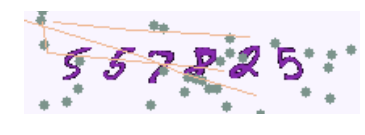

In [5]:
def get_mnist_bbox(img):
    if img[0,0]==255:
        img=255-img 
    img_y=np.greater(np.mean(img,1),0).astype(np.float32)
    img_x=np.greater(np.mean(img,0),0).astype(np.float32)
    min_y,max_y=np.argmax(img_y)-1,len(img_y)-np.argmax(np.flip(img_y.copy(),0))
    min_x,max_x=np.argmax(img_x)-1,len(img_x)-np.argmax(np.flip(img_x.copy(),0))
    return (min_x+max_x)/2.0,(min_y+max_y)/2.0,max_x-min_x+1,max_y-min_y+1

#生成干擾用的隨機線條
def create_noise_curve(image, color):
    h,w = image.shape[:2]
    for i in range(random.choice([1,2,3])):
        try:
            x0=random.randint(0, 20)
            x1 = random.randint(x0, w -3* int(w / 5))
            x2 = random.randint(x1, w -2* int(w / 5))
            x3= random.randint(x2, 208)
            y0= random.randint(int(h /10),int(h / 5))
            y1 = random.randint(y0, h -3*int(h / 5))
            y2 = random.randint(y1, h-2* int(h / 5))
            y3=random.randint(y2, h -int(h / 5))
            points =np.array([[x0, y0], [x1, y1], [x2, y2], [x3, y3]])

            image=cv2.polylines(image,np.int32([points]),False,color =color, thickness=1)
        except Exception as e:
            print(e)
    return image

#生成干擾用的隨機噪點
def create_noise_dots(image, color, width=3, number=30):
    w, h = image.shape[:2]
    while number>0:
        x1 = random.randint(0, 208)
        y1 = random.randint(0, 64)
        cv2.circle(image, (x1, y1),width,color, -1)
        number -= 1
    return image

#隨機生成出隨機數字，數字位置的Bounding Box，以及分別是甚麼數字的標籤集合
def get_minist_chaptcha_raw():
    #隨機設定字數
    words_cnt=random.choice(range(3,7))
    #隨機選擇字體大小
    font_size=random.choice(font_sizes)
    #如果字數太多不巧遇上字體過大，則覆寫為字數等於4
    if font_size*words_cnt>208:
        words_cnt=4
        if font_size*4>208:
            words_cnt=3
    
    #隨機選擇索引位置以及產出對應標籤與圖片
    idx_list=[random.choice(idxs) for d in range(words_cnt)]
    label_list=[np.argmax(labels[d]) for d in idx_list]  
    img_list=[cv2.resize(np.reshape(features[d],(28,28,1)),(font_size,font_size)) for d in idx_list]  
    bboxs_list=[get_mnist_bbox(im) for im in img_list]
    return img_list,bboxs_list,label_list


#根據get_minist_chaptcha_raw函數的產出，組合生成出驗證碼圖片。
#輸出驗證碼圖片尺寸為寬為208 高為64，為何使用208那麼怪的數字主要是後續要透過4次下採樣變成13個特徵圖網格
def get_minist_chaptcha():
    img_list,bboxs_list,label_list= get_minist_chaptcha_raw()
    new_bboxs_list=[]
    #隨機生成顏色
    background = random_color(200, 255)
    color = random_color(40,180)
    image = np.ones((64,208,3))
    image=image*np.reshape(background,(1,1,3))
    pos_x=(208-img_list[0].shape[0]*len(img_list))//2
    pos_y=(64-img_list[0].shape[1])//2
    for i in range(len(bboxs_list)):
        #將灰階轉換為三原色
        imBGR=cv2.cvtColor(img_list[i],cv2.COLOR_GRAY2BGR).astype(np.float32)
        imBGR=imBGR/255.0
        imBGR[imBGR<=0.1]=0
        imBGR=imBGR*np.reshape(color,(1,1,3))
        imBGR[np.where((imBGR==[0,0,0]).all(axis=2))] = background
        
        #接受一個隨機左右偏移量
        pos_x=pos_x+random.choice(np.arange(-3,1).tolist())
       
        
        #取出bbox定義
        (xc,yc,w,h)=bboxs_list[i]
     
        image[pos_y:pos_y+imBGR.shape[0],pos_x:pos_x+imBGR.shape[1],:]=imBGR[:,:,:]
        #塞入新bbox
        new_bboxs_list.append((xc+pos_x,yc+pos_y,w,h))
        pos_x=pos_x+imBGR.shape[1]
    image=create_noise_dots(image,random_color(120,240))
    image=create_noise_curve(image,random_color(120,240,random.randint(180, 255)))
    return image.astype(np.float32),img_list,new_bboxs_list,label_list

img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
img_captcha=cv2.cvtColor(img_captcha,cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))

#我們隨機生成一張驗證碼，並且將它顯示出來
plt.axis('off')
plt.imshow(img_captcha)
print(label_list)

(64, 208, 3)
float32


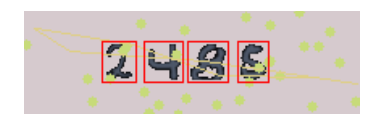

In [6]:
img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
print(img_captcha.shape)
print(img_captcha.dtype)
for bbox in bboxs_list:
    color =(0,0,255)
    (xc,yc,w,h)=bbox
    cv2.rectangle(img_captcha, (int(xc-0.5-0.5*w), int(yc-0.5-0.5*h)), (int(xc+0.5+0.5*w), int(yc+0.5+0.5*h)), color, 1)

img_captcha=cv2.cvtColor(img_captcha,cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))
plt.axis('off')
plt.imshow(img_captcha)   

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


#請注意，原來的tiny yolo v2的輸入圖片為416*416，透過5次下採樣(最後一次maxpolling strides=1，並不是下採樣)產生了大小為13*13的特徵圖
#為了將輸入圖片尺寸縮小方便訓練，以及簡化模型我們將輸入圖片尺寸改為208*208，並且拿掉一組下採樣
# 最後一層特徵圖15=1種anchor*(4個bounding box迴歸參數+1個objectness+10數字類別score)
class simplify_tiny_yolo(nn.Module):
    def __init__(self,num_classes=10):
        super(simplify_tiny_yolo, self).__init__()
        self.conv1 = conv3x3(3, 16, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 =conv3x3(16, 32, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 =conv3x3(32, 64, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 =conv3x3(64, 128, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 =conv3x3(128, 256, 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 =conv3x3(256, 512, 1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 =conv3x3(512, 512, 1)
        self.bn7 = nn.BatchNorm2d(512)
        
        self.conv_xy =conv1x1(512, 2, 1)
        self.conv_wh =conv1x1(512, 2, 1)
        self.conv_obj =conv1x1(512, 1, 1)
        self.conv_class =conv1x1(512, num_classes, 1)
        
        self.leakyrelu = nn.LeakyReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(2, 2)
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()
        
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.leakyrelu(x)
      
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.leakyrelu(x)
      
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.leakyrelu(x)
     
        bbox_xy=self.conv_xy(x)
        bbox_xy=self.sigmoid(bbox_xy)
   
        bbox_wh=self.conv_wh(x)
       
        bbox_obj=self.conv_obj(x)
        bbox_obj=self.sigmoid(bbox_obj)
           
        bbox_class=self.conv_class(x)
        bbox_class=self.softmax(bbox_class)
         
        p=torch.cat((bbox_xy,bbox_wh,bbox_obj,bbox_class),1)
        
        return p
           

![md_images](../Images/bbox_regression.jpg?raw=true)

(3, 208, 208)
(15, 13, 13)
(13, 13)


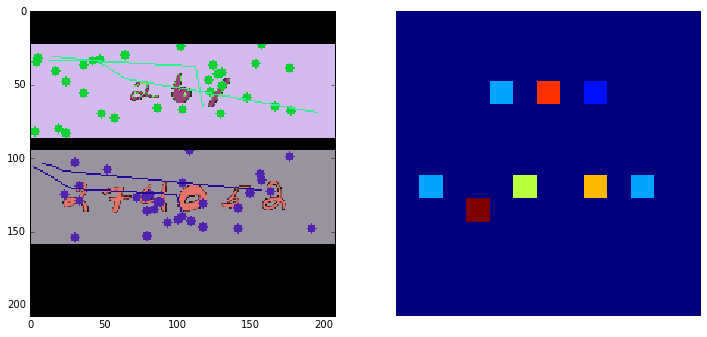

In [8]:
def get_next_minibatch(minibatch_size=1):
    features=[]
    lables=[]
    while len(features)<minibatch_size:
        h_shift=random.choice(range(60))
        h_shift2=h_shift+64+random.choice(range(10))
        img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
        img_captcha2,img_list2,bboxs_list2,label_list2= get_minist_chaptcha()
        
        feature=np.zeros((3,208,208),dtype=np.float32) #輸入向量基礎為全零向量
        
        #數據增強手法，將輸入向量背景變為隨機常態分佈的亂數噪音
        if random.randint(0, 10)%3==0:
            feature=np.random.standard_normal((3,208,208))*127.5+127.5
  
        img_captcha=np.transpose(img_captcha,[2,0,1])
        img_captcha2=np.transpose(img_captcha2,[2,0,1])
        
        feature[:,h_shift:h_shift+img_captcha.shape[1],:]=img_captcha
        feature[:,h_shift2:h_shift2+img_captcha2.shape[1],:]=img_captcha2
        features.append((feature-127.5)/127.5) #將輸入向量標準化為-1~1之間
        
        bboxs_list=[(box[0],box[1]+h_shift,box[2],box[3]) for box in bboxs_list]
        bboxs_list2=[(box[0],box[1]+h_shift2,box[2],box[3]) for box in bboxs_list2]
        
        bboxs_list.extend(bboxs_list2)
        label_list.extend(label_list2)
        
        label=np.zeros((15,13,13),dtype=np.float32)
        for i in range(len(bboxs_list)):
            bbox=bboxs_list[i]
            #print('bbox {0} {1}'.format(i,bbox))
            xc,yc,w,h=bbox[0],bbox[1],bbox[2],bbox[3]
            lab_idx=label_list[i]
            label[0,int(yc//16),int(xc//16)]=(xc-(int(xc//16)*16))/16.
            label[1,int(yc//16),int(xc//16)]=(yc-(int(yc//16)*16))/16.
            label[2,int(yc//16),int(xc//16)]=math.log(w/16.)
            label[3,int(yc//16),int(xc//16)]=math.log(h/16.)
            #bbox中心點位置落點特徵圖網格
            label[4,int(yc//16),int(xc//16)]=1.0  #objectness
            #數字onehot
            label[5+lab_idx,int(yc//16),int(xc//16)]=1 #class
            
        lables.append(label)
    return np.asarray(features).astype(np.float32),np.asarray(lables).astype(np.float32)

features_x,lables_y=get_next_minibatch(1)
print(features_x[0].shape)
print(lables_y[0].shape)
griddata=np.argmax(lables_y[0][5:,:,:],0)
print(griddata.shape)
#print(np.array([row[:] for row in griddata]).shape)


img_captcha=cv2.cvtColor(np.transpose(features_x[0]*255,[1,2,0]),cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))

fig, (feature, label)= plt.subplots(1, 2, figsize=(12, 6))

plt.axis('off')
feature.imshow(img_captcha, interpolation='nearest')
plt.axis('off')
label.imshow(griddata, interpolation='nearest', cmap=None)



In [9]:
num_epochs=5
minibatch_size=16

tiny_yolo=simplify_tiny_yolo(10)
model=tiny_yolo.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
criterion=nn.MSELoss(reduction='sum')

![md_images](../Images/yolo_loss.jpg?raw=true)

In [10]:
losses=[]
metrics=[]

print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    while mbs<=1000:
        input, target_np = get_next_minibatch(minibatch_size)
        input, target = torch.from_numpy(input), torch.from_numpy(target_np)
        input, target = Variable(input).to(device), Variable(target).to(device)
        output = model(input)
        
        mask=torch.unsqueeze(target[:,4,:,:],1)
        #預測與實際的bbox中心
        pred_box_xy = output[:,:2,:,:]
        actual_box_xy = target[:,:2,:,:]

    
        #預測與實際bbox wh
        pred_box_wh = output[:,2:4,:,:]
        actual_box_wh = target[:,2:4,:,:]

        #預測bbox中心objectness
        pred_box_objectness = output[:,4,:,:]
        actual_box_objectness = target[:,4,:,:]

        #預測bbox類別。
        pred_box_class =output[:,5:,:,:]
        actual_box_class =target[:,5:,:,:]
        
        loss=criterion(output,target)+1*criterion(pred_box_xy*mask,actual_box_xy)+5*criterion(pred_box_wh*mask,actual_box_wh)
        +20*criterion(pred_box_objectness* target[:,4,:,:],actual_box_objectness)+0.5*criterion((1-pred_box_objectness)*(1- target[:,4,:,:]),1-actual_box_objectness)
        +10*criterion(pred_box_class*mask,actual_box_class)
        
        
        detector=output.cpu().detach().numpy()
        
   
        box_coverage=np.sum(np.equal(np.greater(detector[:,4,:,:],0.7),target_np[:,4,:,:])*target_np[:,4,:,:]).astype(np.float32)/np.sum(target_np[:,4,:,:])
        box_neg_coverage=np.sum(np.equal(np.less(detector[:,4,:,:],0.7),1-target_np[:,4,:,:])*(1-target_np[:,4,:,:]))/np.sum(1-target_np[:,4,:,:])

        center_shift_error=np.sqrt(np.sum(np.power(detector[:,:2,:,:]-target_np[:,:2,:,:],2)*target_np[:,2:4,:,:]))/np.sum(target_np[:,2:4,:,:])
        scale_error=np.sqrt(np.sum(np.power(np.exp(detector[:,2:4,:,:])-np.exp(target_np[:,2:4,:,:]),2)*target_np[:,2:4,:,:]))/np.sum(target_np[:,4,:,:])
        class_accuracy=np.sum(np.equal(np.argmax(detector[:,5:,:,:],1), np.argmax(target_np[:,5:,:,:],1))*target_np[:,4,:,:])/np.sum(target_np[:,4,:,:])

        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if mbs % 100 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f}...".format(np.asarray(losses).mean()))
            losses=[]
        if mbs % 200 == 0:
            print('候選框命中率:{0:.3%}'.format(box_coverage))
            print('候選框負樣本命中率:{0:.3%}'.format(box_neg_coverage))
            print('中心點偏移誤差:{0:.3%}'.format(center_shift_error))
            print('框縮放比率誤差:{0:.3%}'.format(scale_error))
            print('分類正確率:{0:.3%}'.format(class_accuracy))
            print('')
            torch.save(model, 'Models/chptcha_pytorch.cnn')

        mbs += 1

epoch start
Epoch: 1/5  Step: 0  Loss: 2964.0857...
候選框命中率:0.000%
候選框負樣本命中率:99.922%
中心點偏移誤差:3.162%
框縮放比率誤差:3.383%
分類正確率:13.768%



C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type simplify_tiny_yolo. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/5  Step: 100  Loss: 1025.7530...


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in sqrt


Epoch: 1/5  Step: 200  Loss: 536.1005...
候選框命中率:70.270%
候選框負樣本命中率:99.844%
中心點偏移誤差:2.749%
框縮放比率誤差:0.957%
分類正確率:23.649%

Epoch: 1/5  Step: 300  Loss: 453.5064...
Epoch: 1/5  Step: 400  Loss: 428.7980...
候選框命中率:88.158%
候選框負樣本命中率:99.726%
中心點偏移誤差:1.626%
框縮放比率誤差:0.735%
分類正確率:23.026%

Epoch: 1/5  Step: 500  Loss: 417.9000...
Epoch: 1/5  Step: 600  Loss: 401.0022...
候選框命中率:95.070%
候選框負樣本命中率:99.883%
中心點偏移誤差:0.881%
框縮放比率誤差:0.575%
分類正確率:52.113%

Epoch: 1/5  Step: 700  Loss: 380.7561...
Epoch: 1/5  Step: 800  Loss: 355.7767...
候選框命中率:95.862%
候選框負樣本命中率:99.922%
中心點偏移誤差:1.049%
框縮放比率誤差:0.516%
分類正確率:75.172%

Epoch: 1/5  Step: 900  Loss: 338.4576...


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in sqrt


Epoch: 1/5  Step: 1000  Loss: 330.2969...
候選框命中率:92.857%
候選框負樣本命中率:99.922%
中心點偏移誤差:1.485%
框縮放比率誤差:0.553%
分類正確率:81.429%

Epoch: 2/5  Step: 0  Loss: 327.5687...
候選框命中率:93.289%
候選框負樣本命中率:99.922%
中心點偏移誤差:1.317%
框縮放比率誤差:0.823%
分類正確率:87.248%

Epoch: 2/5  Step: 100  Loss: 320.0183...
Epoch: 2/5  Step: 200  Loss: 317.6338...
候選框命中率:97.222%
候選框負樣本命中率:99.922%
中心點偏移誤差:1.068%
框縮放比率誤差:0.411%
分類正確率:98.611%

Epoch: 2/5  Step: 300  Loss: 314.1073...
Epoch: 2/5  Step: 400  Loss: 307.8407...
候選框命中率:94.853%
候選框負樣本命中率:99.883%
中心點偏移誤差:0.965%
框縮放比率誤差:0.590%
分類正確率:92.647%

Epoch: 2/5  Step: 500  Loss: 307.2946...
Epoch: 2/5  Step: 600  Loss: 305.1779...
候選框命中率:97.297%
候選框負樣本命中率:99.961%
中心點偏移誤差:0.826%
框縮放比率誤差:0.395%
分類正確率:96.622%

Epoch: 2/5  Step: 700  Loss: 302.8856...
Epoch: 2/5  Step: 800  Loss: 303.5612...
候選框命中率:96.528%
候選框負樣本命中率:99.922%
中心點偏移誤差:0.967%
框縮放比率誤差:0.441%
分類正確率:92.361%

Epoch: 2/5  Step: 900  Loss: 299.6534...
Epoch: 2/5  Step: 1000  Loss: 297.8429...
候選框命中率:98.529%
候選框負樣本命中率:99.961%
中心點偏移誤差

(208, 208, 3)
預測框向量:[ 0.8174945   0.8044594  -0.06861062  0.35566583  0.9995146 ]
實際框向量:[ 0.78125     0.78125    -0.13353139  0.31845373  1.        ]
預測框向量:[0.5694437  0.797476   0.18759523 0.31877822 0.99901235]
實際框向量:[0.46875    0.78125    0.11778303 0.31845373 1.        ]
預測框向量:[0.20145153 0.68666226 0.16524065 0.29273796 0.99915886]
實際框向量:[0.21875    0.65625    0.11778303 0.31845373 1.        ]
預測框向量:[0.4840156  0.03429411 0.21414873 0.48719677 0.9423851 ]
實際框向量:[0.40625    0.03125    0.22314355 0.48550782 1.        ]
預測框向量:[0.3489641  0.09814603 0.21499288 0.4888592  0.9995628 ]
實際框向量:[0.3125     0.09375    0.17185026 0.48550782 1.        ]
預測框向量:[0.01563913 0.06913835 0.09017774 0.44834602 0.80723315]
實際框向量:[0. 0. 0. 0. 0.]
預測框向量:[ 0.89081943  0.06667756 -0.07054268  0.47515148  0.9816436 ]
實際框向量:[ 0.90625     0.03125    -0.13353139  0.48550782  1.        ]
預測結果:[3, 4, 6, 4, 4, 1, 1]
信心水準:[0.9995146, 0.99901235, 0.99915886, 0.9423851, 0.9995628, 0.80723315, 0.9816436]
實際結果:[3, 4,

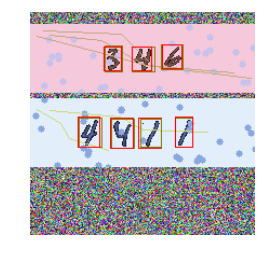

In [13]:
features_x,lables_y=get_next_minibatch(1)
input, target = torch.from_numpy(features_x), torch.from_numpy(lables_y)
input, target = Variable(input).to(device), Variable(target).to(device)
result=model(input).cpu().detach().numpy()

test_captcha=np.transpose(features_x[0]*127.5+127.5,[1,2,0]).astype(np.float32)#把向量轉成opencv的HWC模式
test_captcha=test_captcha.copy()

print(test_captcha.shape)

#print(result[0][4,:,:])
#print(sigmoid_np(result[0][4,:,:]).max())

words=[]
confidences=[]
answers=[]
for j in range(13):
    for i in range(13):
        #預測的邊界框
        if result[0][4,j,i]>=0.7: #如果objectness>0.7
            print('預測框向量:{0}'.format(result[0][:5,j,i]))
            print('實際框向量:{0}'.format(lables_y[0][:5,j,i]))
            pred_class=np.argmax(result[0][5:,j,i]) #預測類別
            words.append(pred_class)
            confidences.append(result[0][4,j,i])
            pred_xc=i*16+(result[0][0,j,i])*16.0
            pred_yc=j*16+(result[0][1,j,i])*16.0
            pred_w=math.exp(result[0][2,j,i])*16.0
            pred_h=math.exp(result[0][3,j,i])*16.0
            color =(0,128,128)
            cv2.rectangle(test_captcha, (int(pred_xc-0.5-0.5*pred_w), int(pred_yc-0.5-0.5*pred_h)), (int(pred_xc+0.5+0.5*pred_w), int(pred_yc+0.5+0.5*pred_h)), color, 1)
        #實際的邊界框
        if lables_y[0][4,j,i]>0.7: #如果objectness>0.5
            actual_class=np.argmax(lables_y[0][5:,j,i]) #預測類別
            answers.append(actual_class)
            actual_xc=i*16+(lables_y[0][0,j,i]*16.0)
            actual_yc=j*16+(lables_y[0][1,j,i]*16.0)
            actual_w=math.exp(lables_y[0][2,j,i])*16.0
            actual_h=math.exp(lables_y[0][3,j,i])*16.0
            color =(0,0,255)
            cv2.rectangle(test_captcha, (int(actual_xc-0.5-0.5*actual_w), int(actual_yc-0.5-0.5*actual_h)), (int(actual_xc+0.5+0.5*actual_w), int(actual_yc+0.5+0.5*actual_h)), color, 1)
  
            
test_captcha=cv2.cvtColor(test_captcha,cv2.COLOR_BGR2RGB)
test_captcha=Image.fromarray(test_captcha.astype(np.uint8))



print('預測結果:{0}'.format(words))
print('信心水準:{0}'.format(confidences))
print('實際結果:{0}'.format(answers))

plt.axis('off')
plt.imshow(test_captcha)
